# XRD Analysis

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os.path
import seaborn as sns

sns.set_style("white")

In [45]:
def get_filepaths(filenames, rootdir=os.getcwd() + "/data/"):
    if "/" != rootdir[-1]:
        rootdir = rootdir + "/"

    if isinstance(filenames, list) == False:
        filenames = [filenames]
    
    # get valid filepaths
    file_paths = {}
    for filename in filenames:
        # filenames have to be unique, as this searches all subdirectories from the root directory
        search_results = glob.glob("**/*" + filename + "*", recursive=True, root_dir=rootdir)

        if 0 == len(search_results):
            raise Exception(f"Sorry friend, the file \"" + filename + "\" was not found in any of the subdirectories of " + rootdir)
        
        if 1 < len(search_results):
            raise Exception(f"Sorry friend, the file \"" + filename + "\" was found in multiple locations within the subdirectories of "
                            + rootdir + "\n" + str(search_results) + " \nBe more specific about the file in question or delete any copies you might have.")
        
        # get the one found path
        found_path = glob.glob("**/*" + filename + "*", recursive=True, root_dir=rootdir)[0]

        # put them in the big dictionary of absolute file_paths, with the key being the file name (without extension)
        file_paths[found_path[found_path.rfind("\\")+1 : found_path.rfind(".")]] = rootdir + found_path

    return file_paths

def read_XRD(file_paths):
    # read the data from the files to dataframes (skip headers for now)
    XRD_dfs = {}
    for filename in file_paths:
        with open(file_paths[filename]) as f:
            if (filename + ".ras") in file_paths[filename]:
                # TODO maybe do more checks to see if the given ras file has XRD data in it and not other nonsense?
                lines = (line for line in f if not line.startswith('*'))
                XRD_dfs[filename] = pd.DataFrame(np.loadtxt(lines, delimiter=' ')).drop(columns=2).rename(columns={0:"angle", 1:"intensity"})
            elif (filename + ".csv") in file_paths[filename]:
                for line in f:
                    if "[Scan points]" in line:
                        break
                
                # in python the iterating variable is kept outside for loop. Here reaching EoF gives an empty string
                if "" == line:
                    raise Exception("You wanted to read \'" + filename + "\', which is indeed a csv file, but not an output of the powder XRD machine.")
                
                # no need for the header parameter: the file reader has already iterated past the header
                XRD_dfs[filename] = pd.read_csv(f, delimiter=", ", engine="python").drop(columns=["TimePerStep", "ESD"]).rename(columns={"Angle": "angle", "Intensity":"intensity"})
            else:
                raise Exception("The file given, " + filename + " is not a csv or a ras file, which means it's probably not XRD data. Check your inputs.")
            
    return XRD_dfs

def read_peaks(file_paths):
    peak_dfs = {}
    for filename in file_paths:
        with open(file_paths[filename]) as f:
            peak_dfs[filename] = pd.read_csv(f, delimiter="\t").drop(
                columns=["H", "K", "L", "D-VALUE", "MULT"]).rename(columns={"2THETA": "angle", "INTENSITY": "intensity"})
    
    return peak_dfs

def plot_XRD(XRD_dfs, peak_dfs,
             XRD_labels=[], peak_labels=[], fig_title="XRD",
             min_angle=0, max_angle=120, smoothing_window_angle=0.001,
             save_fig=False):

    # check if the user gave enough labels, and return the labels in dict form
    def fix_labels(dfs_length, dfs_keys, labels, stuffing):
        if (dfs_length < len(labels)):
            labels = labels[0:dfs_length]
        else:
            [labels.append(stuffing) for i in np.arange(dfs_length - len(labels))]
        
        # this will have the same keys as the data
        label_dict = {}
        for i in np.arange(len(labels)):
            label_dict[dfs_keys[i]] = labels[i]

        return label_dict
    
    XRD_labels = fix_labels(len(XRD_dfs), list(XRD_dfs.keys()), XRD_labels, "XRD label")
    peak_labels = fix_labels(len(peak_dfs), list(peak_dfs.keys()), peak_labels, "peak label")
    
    # this function copies the data and trims it to the specified angles
    max_data_intensity = 20
    def cut_dfs(dfs):
        dfs_copy = {}
        for df_name in dfs:
            dfs_copy[df_name] = dfs[df_name][ (min_angle < dfs[df_name].angle) & (dfs[df_name].angle < max_angle) ].reset_index().drop(columns=["index"])
        return dfs_copy
    
    XRD_dfs = cut_dfs(XRD_dfs)
    peak_dfs = cut_dfs(peak_dfs)

    # smooth the data using the given smoothing angle window
    for df_name in XRD_dfs:
        smooth_wind = smoothing_window_angle / (XRD_dfs[df_name].angle.iloc[1] - XRD_dfs[df_name].angle.iloc[0])
        smooth_wind = int(np.around(smooth_wind))

        if 1 < smooth_wind:
            XRD_dfs[df_name].intensity = XRD_dfs[df_name].intensity.rolling(smooth_wind).sum() / smooth_wind
        
        # get the maximum of the data for later normalization
        if max_data_intensity < XRD_dfs[df_name].intensity.max():
            max_data_intensity = XRD_dfs[df_name].intensity.max()
    
    fig, ax = plt.subplots(figsize=(8,6))

    XRD_colors = ['#2b8cbe', '#a6bddb', '#ece7f2']
    color_counter = 0
    for df_name in XRD_dfs:
        ax.plot(XRD_dfs[df_name].angle, XRD_dfs[df_name].intensity, label=XRD_labels[df_name], color=XRD_colors[color_counter])
        color_counter += 1
    
    peak_colors = ['#f03b20', '#feb24c', '#ffeda0']
    color_counter = 0
    for df_name in peak_dfs:
        normalization = max_data_intensity / peak_dfs[df_name].intensity.max()
        ax.vlines(peak_dfs[df_name].angle, ymin=0, ymax=peak_dfs[df_name].intensity * normalization / 3, colors=peak_colors[color_counter], label=peak_labels[df_name])
        color_counter += 1

    ax.set(xlabel="2$\\theta$ (deg)", ylabel="Intensity (arbitrary units)")
    ax.legend(fontsize=14)
    ax.set_title(fig_title, fontsize=20)
    


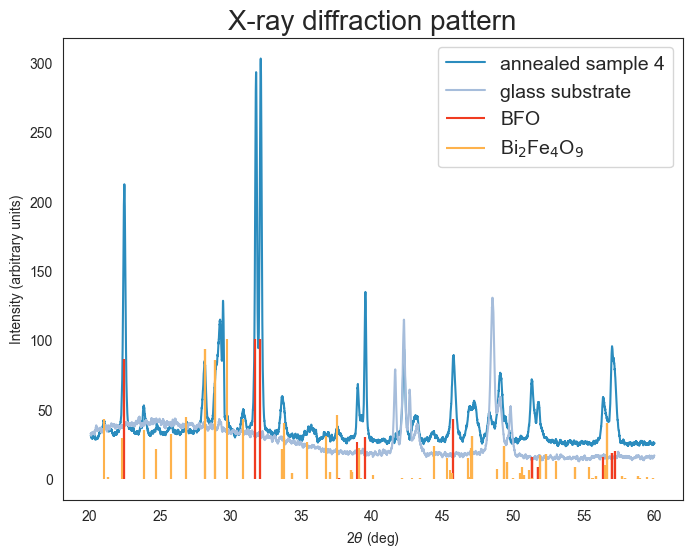

In [46]:
XRD_filepaths = get_filepaths(["double", "sub_glass_sample_8"])
peaks_filepaths = get_filepaths(["peaks_BFO", "peaks_Bi2Fe4O9"])
XRD_dfs = read_XRD(XRD_filepaths)
peak_dfs = read_peaks(peaks_filepaths)
plot_XRD(XRD_dfs=XRD_dfs, peak_dfs=peak_dfs, XRD_labels=["annealed sample 4", "glass substrate"], peak_labels=["BFO", "Bi$_2$Fe$_4$O$_9$"],
         min_angle=20, max_angle=60, fig_title="X-ray diffraction pattern",
         smoothing_window_angle=0.1)

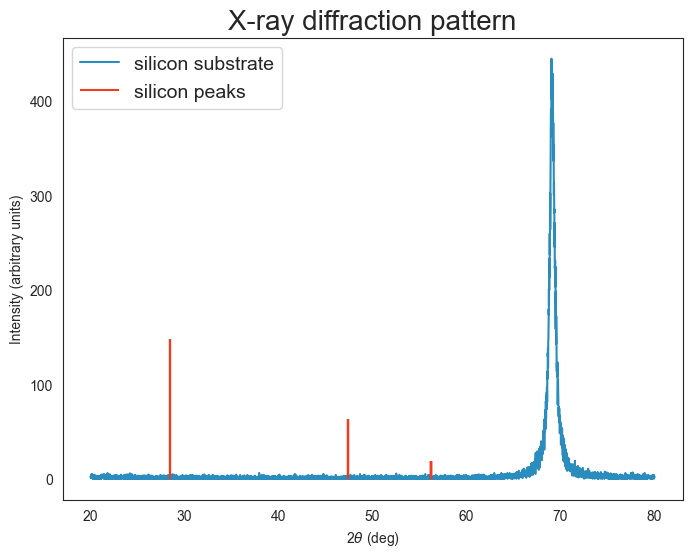

In [52]:
XRD_filepaths = get_filepaths(["Si_substrate"])
peaks_filepaths = get_filepaths(["peaks_Si"])
XRD_dfs = read_XRD(XRD_filepaths)
peak_dfs = read_peaks(peaks_filepaths)
plot_XRD(XRD_dfs=XRD_dfs, peak_dfs=peak_dfs, XRD_labels=["silicon substrate"], peak_labels=["silicon peaks"],
         min_angle=20, max_angle=80, fig_title="X-ray diffraction pattern",
         smoothing_window_angle=0.01)